---
title: "Retail Gasoline Merger in Chile: An Ex-Post Merger Evaluation"
author: Daniel Redel
date: "2024-04-22"
categories: [Causal Inference, Competition & Antitrust, Diff-in-Diff, Econometrics, Spatial Analysis, Gasoline Industry]
image: "gasoline.png"
toc: true
format:
  html:
    toc: true
    code-fold: false
    html-math-method: katex
jupyter: python3
---

In [1]:
#| echo: false
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Ex-post assessments of merger effects in Chilean's retail gasoline market.

# 1. Introduction

**Ex-post assessments of merger effects** offer competition authorities the chance to retrospectively evaluate previous merger decisions, examining whether their conclusions and final verdict unfolded as expected or could have been improved. Despite their importance, such evaluations are often hindered by data constraints and resource limitations.

In this article, I attempt to address this gap by examining a merger case within the retail gasoline market in Chile. Specifically, I analyze the acquisition of an independent service station (CGL) by the market's dominant player (COPEC) to evaluate its effects on prices in the local gasoline retail market ([FNE F65-2016, Chile](https://www.fne.gob.cl/wp-content/uploads/2016/12/inpu_F65_16.pdf)). My goal is to ascertain whether this merger resulted in heightened consumer prices and increased market concentration. 

Recent concerns expressed by Chilean legislators regarding potential anticompetitive practices among gasoline retailers underscore the urgency of such investigations. Moreover, the Chilean Competition Authority has flagged the Chilean gasoline market for its high concentration levels and significant entry barriers, amplifying the potential risks of post-merger unilateral and coordinated effects. 

To shed light on these issues, I will employ a standard [**difference-in-differences**](https://mixtape.scunning.com/09-difference_in_differences) (DiD) method to causally assess the impact of this particular merger on gasoline prices. This econometric approach enables us to compare the geographic market affected by the increased market concentration resulting from the acquisition with unaffected geographic markets within the region.

This project is a truly enjoyable way of delving into the fascinating worlds of competition economics, causal inference, and Python coding. Let's go!

# 2. The Merger

On April 18, 2016, _Compañia de Petroleos de Chile COPEC S.A._ (COPEC) and _Inmobiliaria y Administradora CGL Limitada_ (CGL) notified the Chilean competition authority, the **[Fiscalia Nacional Economica](https://www.fne.gob.cl/en/)** (FNE), of COPEC's intention to acquire real estate assets and lease contract rights for a CGL's service station located on the Ancud-Castro route in Chiloe Island (Los Lagos Region). 

On that period, CGL was a company with a network of 6 service stations, acquired as part of the divestment process ordered by the Supreme Court following the [Shell-Terpel merger](https://www.latercera.com/pulso/suprema-revierte-fallo-del-tdlc-y-aprueba-fusion-shell-terpel/). 

COPEC, on the other hand, is a subsidiary responsible for the liquid fuels business of Empresas COPEC. In 2015, COPEC operated 627 service stations from Arica to Puerto Williams, covering virtually the entire Chilean territory. Additionally, COPEC owned 6 stations on Chiloe Island at the time of the merger. 

In August 2016, the FNE initiated an investigation into the potential competitive effects of the merger, ultimately approving it in December 2016 after dismissing potential anti-competitive effects.

My goal is to conduct an **ex post merger evaluation** of their competitive effects, assessing whether the FNE's decision was indeed correct.

# 3. Data and Sample

The dataset used for my empirical strategy relies on a panel dataset sourced from [_www.bencinaenlinea.cl_](https://www.bencinaenlinea.cl/), an initiative by the Chilean Energy Ministry that offers comprehensive information on gas station prices nationwide. Each observation in the database contains the price charged by each station, the date each price modification, the station’s geo-location, the brand affiliation of the station and gasoline type (93, 97, Diesel).

To ensure the manageability and relevance of the dataset, I opted to streamline the observations by focusing solely on **the latest posted price of each station within a given month**, resulting in a reduced dataset comprising 61,114 observations. This approach, despite the original dataset encompassing 2,712,543 observations spanning from 2015 to 2021, allows for a more concise and targeted analysis.

Given that the specific merger under scrutiny occurred within the Region of Los Lagos, I restricted my observations to stations within this region. However, to maintain an adequate sample size, I expanded the scope to include stations from its neighboring region, Los Rios. Both regions are part of the Chilean South Macro-Zone, ensuring geographic coherence within the analysis.

@tbl-raw-dataset provides the first few rows of the dataset, offering a concise overview of the variables under consideration:

In [2]:
#| label: tbl-raw-dataset
#| tbl-cap: Gasoline Retail Dataset
#| echo: false

# Import CSV file into DataFrame
df = pd.read_csv('clean_dataset.csv')

# Define lists
macrozonasur = ["Los Lagos", "Los Rios"]
df = df[df['Region'].isin(macrozonasur)]

# sh1020101 <- Estación Objeto Castro - Ruta 5 Sur, km 1170 0 
target_crs = [-42.470071, -73.76461]

# Display the DataFrame
df.head(4)

,Id,Combustible,date,Razon Social,Precio,Fecha Actualiza,Direccion,Latitud,Longitud,Comuna,Region,Nombre Distribuidor,autoservicio,bano_publico,servicios_mantencion,tienda_conveniencia,farmacia
0,co1010101,Gasolina 93,2015-01,CODEPA LTDA.,673.0,2015-01-29 00:08:19,AV. ANGELMO 1920,-41.481484,-72.955876,Puerto Montt,Los Lagos,COPEC,0,0,0,0,0
1,co1010101,Gasolina 93,2015-02,CODEPA LTDA.,693.0,2015-02-26 00:06:21,AV. ANGELMO 1920,-41.481484,-72.955876,Puerto Montt,Los Lagos,COPEC,0,0,0,0,0
2,co1010101,Gasolina 93,2015-03,CODEPA LTDA.,709.0,2015-03-26 00:17:21,AV. ANGELMO 1920,-41.481484,-72.955876,Puerto Montt,Los Lagos,COPEC,0,0,0,0,0
3,co1010101,Gasolina 93,2015-04,CODEPA LTDA.,742.0,2015-04-30 14:28:02,AV. ANGELMO 1920,-41.481484,-72.955876,Puerto Montt,Los Lagos,COPEC,0,0,0,0,0


@fig-map1 presents a visual representation of the service station locations, offering insights into pricing differentials across geographical areas. The left panel depicts a map with stations color-coded by price gradient. In contrast, the right panel focuses on stations most likely impacted by the merger due to their proximity, all situated within the Commune of Castro on Chiloe Island:

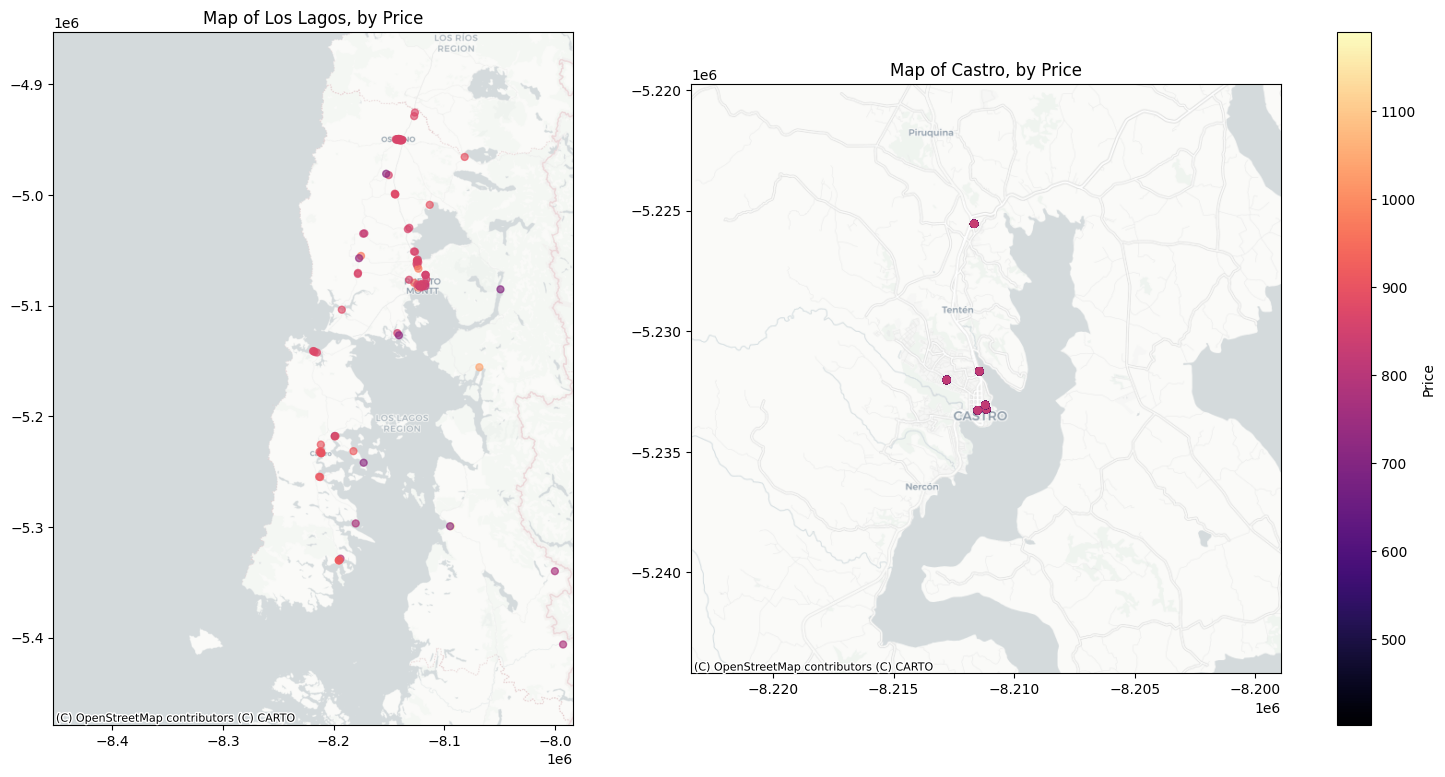

In [37]:
#| label: fig-map1
#| fig-cap: Map with Service Stations, by Price
#| code-fold: true

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as mcolors

# MAP 1
# Filter GeoDataFrame by Region=='Los Lagos'
df_lagos = df[df['Region'] == 'Los Lagos']
price_id = df_lagos.groupby('Id').agg({'Precio': 'mean', 'Latitud': 'first', 'Longitud': 'first'}).reset_index()

# GeoDataFrame
gdf1 = gpd.GeoDataFrame(price_id, geometry=gpd.points_from_xy(price_id.Longitud, price_id.Latitud), crs="EPSG:4326")
gdf1 = gdf1.to_crs(epsg=3857)

# Bbox
west1, south1, east1, north1 = (-75, -43.640, -71.8, -40.426)
basemap1, extent1 = ctx.bounds2img(west1, south1, east1, north1, ll=True, source=ctx.providers.CartoDB.Positron)

# MAP 2
# Filter GeoDataFrame by Comuna=='Castro'
df_castro = df[df['Comuna'] == 'Castro']
gdf2 = gpd.GeoDataFrame(df_castro, geometry=gpd.points_from_xy(df_castro.Longitud, df_castro.Latitud), crs="EPSG:4326")
gdf2 = gdf2.to_crs(epsg=3857)

# Bbox
west2, south2, east2, north2 = (-73.83, -42.5458, -73.69, -42.4073)
basemap2, extent2 = ctx.bounds2img(west2, south2, east2, north2, ll=True, source=ctx.providers.CartoDB.Positron)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

# Plot MAP 1
gdf1.plot(column='Precio', alpha=0.65, cmap='magma', legend=False, ax=axs[0], markersize=25)
axs[0].axis(extent1)
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron)
axs[0].set_title('Map of Los Lagos, by Price')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

# Plot MAP 2
gdf2.plot(column='Precio', alpha=0.65, cmap='magma', legend=False, ax=axs[1], markersize=25)
axs[1].axis(extent2)
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron)
axs[1].set_title('Map of Castro, by Price')
axs[1].set_xlabel('')
axs[1].set_ylabel('')

# Add colorbar
norm = mcolors.Normalize(vmin=min(df['Precio']), vmax=max(df['Precio']))
sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
sm.set_array([])  # required for matplotlib 3.1 and later
cbar = plt.colorbar(sm, ax=axs.ravel().tolist(), orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('Price')

plt.show()

# 4. Empirical Strategy

## 4.1. Identification Strategy

A simple before-after comparison will lead to biased estimates of the merger effects, given that observed price changes might stem from changes in demand or costs. Therefore, we aim to compare price changes around the merger to a **counterfactual scenario** in which no merger took place. Based on ex-post merger evaluation literature ([Dafny et al. [2012]](https://www.aeaweb.org/articles?id=10.1257/aer.102.2.1161); [Ashenfelter et al. [2015]](https://onlinelibrary.wiley.com/doi/abs/10.1111/1756-2171.12092); [Argentesi et al. [2021]](https://www.sciencedirect.com/science/article/abs/pii/S0167718721000825)), I compare the geographical market in which both the acquirer (COPEC) and the target (CGL) operated in the pre-merger period to control markets that did not experience a change in market concentration. 

My **identification strategy** relies on the expectation that competitive effects of the merger are likely to be stronger in the so-called **overlap area** between the merging parties than in **non-overlap areas** where the parties did not compete with each other door to door, since only in overlap areas did the intensity of competition change because of the merger. We thus can compare areas that experienced a change in market concentration (**treated group**) to markets without a pre-merger overlap (**control group**). Finally, this causal effect can be identified by employing a [**Difference-in-Differences**](https://mixtape.scunning.com/09-difference_in_differences) (DiD) methodology that compares overlap and non-overlap areas to get the Average Treatment Effects on the Treated at the local level. 

Another assumption that is implicitly here is the assumption that in retail gasoline markets competition works at the local level. Any comparison between treated and control areas will be able to identify merger treatment effects only if competition is, at least to some extent, local. Although in this article we will not provide evidence to support this, previous literature tend to suggest that retail gasoline market is local rather than national (see [here](https://link.springer.com/article/10.1007/s10842-017-0249-0) and [here](https://link.springer.com/article/10.1023/B:ECOT.0000006590.66223.9a)).



### 4.1.1. Geographical Relevant Market

The impact of COPEC's acquisition on the market structure around each gas station is measured as the change in the number of independent competing brands within a specific radius. However, determining the appropriate radius size is a critical consideration, not to be underestimated.

The Chilean competition authority (FNE), in its [merger report](https://www.fne.gob.cl/wp-content/uploads/2016/12/inpu_F65_16.pdf), defined the relevant geographical market as the entire Castro County/Commune. According to their assessment, this determination was based on jurisprudence, which considers the local or communal market due to the difficulties and costs consumers face in traveling between gas stations in terms of time, convenience, and fuel expenses. Additionally, international jurisprudence has also noted that **retail operators typically operate in local markets**, monitoring competitor prices within a relatively limited radius, typically around 3 miles (approximately 5 kilometers), or based on travel isochrones of 10 minutes for urban areas and 20 minutes for rural areas ([Case No. ME/3933/08](https://www.gov.uk/cma-cases/co-operative-group-lothian-borders-and-angus-co-operative-society)). Consequently, I will **adopt a 5 km radius** to delineate the geographical relevant markets.

In [3]:
#| code-fold: true

import geopandas as gpd
from shapely.geometry import Point

# Filter the DataFrame for the unit with Id='co1020101'
unit_co1020101 = df[df['Id'] == 'co1020101']

# Get the unique latitude and longitude values
unique_latitudes = unit_co1020101['Latitud'].unique()
unique_longitudes = unit_co1020101['Longitud'].unique()

# Target coordinates (longitude, latitude)
target_crs = (unique_longitudes, unique_latitudes)

# Convert DataFrame to GeoDataFrame
grouped_df = df.groupby('Id').agg({'Latitud': 'first', 'Longitud': 'first'}).reset_index()
new_df = pd.DataFrame(grouped_df)
gdf_units = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df.Longitud, new_df.Latitud), crs="EPSG:4326")

# Create a Shapely Point object for the target coordinates
target_point = gpd.GeoDataFrame({'geometry': [Point(target_crs)]}, crs="EPSG:4326")
# Buffer the point to create a circle with a radius of 5000 meters
buffer_radius_deg = 5000 / 111000  # 1 degree of latitude is approximately 111000 meters

buffer_circle = target_point.buffer(buffer_radius_deg)
buffer_area = buffer_circle.to_crs(gdf_units.crs)

# Check if each unit's coordinates fall within the buffer circle
gdf_units['treat'] = gdf_units.geometry.within(buffer_area.iloc[0])

# Convert treat column to integer (1 for True, 0 for False)
gdf_units['treat'] = gdf_units['treat'].astype(int)
gdf_units['Treated'] = np.where(gdf_units['treat'] == 1, 'Treated', 'Control')
df = pd.merge(df, gdf_units[['Id', 'Treated', 'treat']], on='Id', how='left')

# Count treated and control units
treated_count = gdf_units['treat'].value_counts()[1]
control_count = gdf_units['treat'].value_counts()[0]

print("Treated units:", treated_count)
print("Control units:", control_count)


Treated units: 6
Control units: 150


This selection process resulted in a total of 6 service stations falling within the defined overlap area, thus constituting the treated group. The remaining 150 stations outside this area will serve as the control group. @fig-map2 provides a visual and interactive representation of the spatial distribution of these stations:

In [83]:
#| label: fig-map2
#| fig-cap: Map with Treated Service Stations
#| code-fold: true
import folium
from folium.plugins import MarkerCluster

# Filter GeoDataFrame by Region=='Castro'
df_lagos = df[df['Region'] == 'Los Lagos']
df_lagos = df_lagos.dropna(subset=['Latitud', 'Longitud'])
price_id = df_lagos.groupby('Id').agg({'Precio': 'mean', 'Latitud': 'first', 'Longitud': 'first'}).reset_index()
gdf = gpd.GeoDataFrame(price_id, geometry=gpd.points_from_xy(price_id.Longitud, price_id.Latitud), crs="EPSG:4326")

# Create a map centered around Los Lagos region
target_crs = [-42.470071, -73.76461]
m = folium.Map(location=target_crs, zoom_start=11)

# Create a MarkerCluster to add all the points
marker_cluster = MarkerCluster().add_to(m)

# # Iterate over each row in the GeoDataFrame and add a marker to the map
for idx, row in gdf.iterrows():
    folium.Marker(location=[row['Latitud'], row['Longitud']], popup=row['Id'], 
                  ).add_to(marker_cluster)

radius = 5000
folium.Circle(
    location=target_crs,
    radius=radius,
    color="black",
    weight=1,
    fill_opacity=0.1,
    opacity=1,
    fill_color="blue",
    fill=False,  # gets overridden by fill_color
    popup="{} meters".format(radius),
    tooltip="I am in meters",
).add_to(m)

# Show
m

### 4.1.2. Treatment Period

Regarding the treatment period, it's important to acknowledge that certain treated service stations ceased price postings during the interval between the merger approval (December 2016) and the beginning of operations under the re-branded identity (around January 2018). Consequently, observations within this transitional period are excluded from analysis, aligning the last pre-merger period with November 2016 and the first post-merger period with February 2018.

In [4]:
#| code-fold: true
import pandas as pd

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = df['date'].dt.to_period('M')

# Define the date thresholds
post_date_1 = pd.to_datetime("2016-12-02")
post_date_2 = pd.to_datetime("2017-11-01")

# Create 'Post' variable
df['Post'] = (df['date'] >= post_date_1).astype(int)

# Create 'post1' variable
df['post1'] = ((df['date'] >= post_date_1) & (df['date'] < post_date_2)).astype(int)

# Create 'post2' variable
df['post2'] = (df['date'] >= post_date_2).astype(int)


# sh1020101 comes back at 2017-11-30 or 11
# pe1020101 comes back at 2018-02-22 or 14

# Filter the DataFrame for Balanced Panel
df = df[ (df['date'] >= pd.to_datetime("2018-02-22")) | (df['date'] <= pd.to_datetime("2016-12-02"))  ]

# Get unique dates
unique_dates = sorted(set(df['date']))

# Create DataFrame from unique dates
unique_dates_df = pd.DataFrame({'date': unique_dates})

# Add a new column containing numbers from 1 to the number of rows
unique_dates_df['event_date'] = range(1 - 25 , len(unique_dates_df) + 1 - 25)

# Merge with original DataFrame based on 'date' column
df = pd.merge(df, unique_dates_df, on='date', how='left')

In [5]:
#| code-fold: true

# Count occurrences of each Id
id_counts = df['Id'].value_counts()

# Check if it's a balanced panel
balanced_panel = id_counts.nunique() == 1

# If not balanced, identify Id with different counts
if not balanced_panel:
    unbalanced_ids = id_counts[id_counts != id_counts.iloc[0]].index
    
    # Remove rows corresponding to unbalanced Id
    df = df[~df['Id'].isin(unbalanced_ids)]

# Print the balanced panel status and the number of rows after removing unbalanced Ids
print("Is it a balanced panel?", balanced_panel)
print("Number of rows after removing unbalanced Ids:", len(df))

# Check if 'sh1020101' and 'pe1020101' are in the filtered DataFrame
treated_ids = ['sh1020101', 'pe1020101']
removed_ids = [id for id in treated_ids if id not in df['Id'].unique()]

# Print the result
if removed_ids:
    print("The following treated Ids were removed:", removed_ids)
else:
    print("All treated Ids are still present in the DataFrame.")

Is it a balanced panel? False
Number of rows after removing unbalanced Ids: 18423
All treated Ids are still present in the DataFrame.


Furthermore, to ensure a balanced panel dataset, additional stations with irregular posting behavior during the relevant study period are excluded. Following these adjustments, the dataset comprises 18,423 observations.

## 4.2. Summary Statistics

@tbl-summary1 and @tbl-summary2 offer summary statistics on both the treated and non-treated units within the dataset. 

In [19]:
#| label: tbl-summary1
#| tbl-cap: Pre-Merger Sample of Service Stations
#| code-fold: true

# Create a new column 'Brand' based on conditions
df['Brand'] = np.where(df['Nombre Distribuidor'] == 'COPEC', 'COPEC', 'Branded Rivals')
df.loc[df['Id'] == 'sh1020101', 'Brand'] = 'Non Branded'

# Pivot the dataframe with 'treat' as columns
summary_stats = df.groupby(['treat', 'Brand'])['Id'].nunique().reset_index(name='Id')

pivot_summary_stats = summary_stats.pivot_table(index='Brand', columns='treat', values='Id', fill_value=0)

# Print the pivot table
pivot_summary_stats


treat,0,1
Brand,,
Branded Rivals,46,3
COPEC,37,2
Non Branded,0,1


In [26]:
#| label: tbl-summary2
#| tbl-cap: Preliminary Summary Statistics
#| code-fold: true

# Pivot the dataframe to have 'Combustible' values as columns
avg_summary = df.groupby(['treat', 'Post', 'Combustible'])['Precio'].mean().reset_index()
pivot_avg_summary = avg_summary.pivot_table(index=['Combustible', 'treat'], columns='Post', values='Precio')
pivot_avg_summary.round(1)

Post                       0      1
Combustible     treat              
Gasolina 93     0      727.1  844.8
                1      735.4  858.8
Gasolina 97     0      805.8  902.9
                1      815.4  918.2
Petroleo Diesel 0      501.1  622.8
                1      515.3  639.4

@fig-price-treat illustrates the comparative trajectory of average gasoline prices per type in the treated area against those in non-treated areas. 

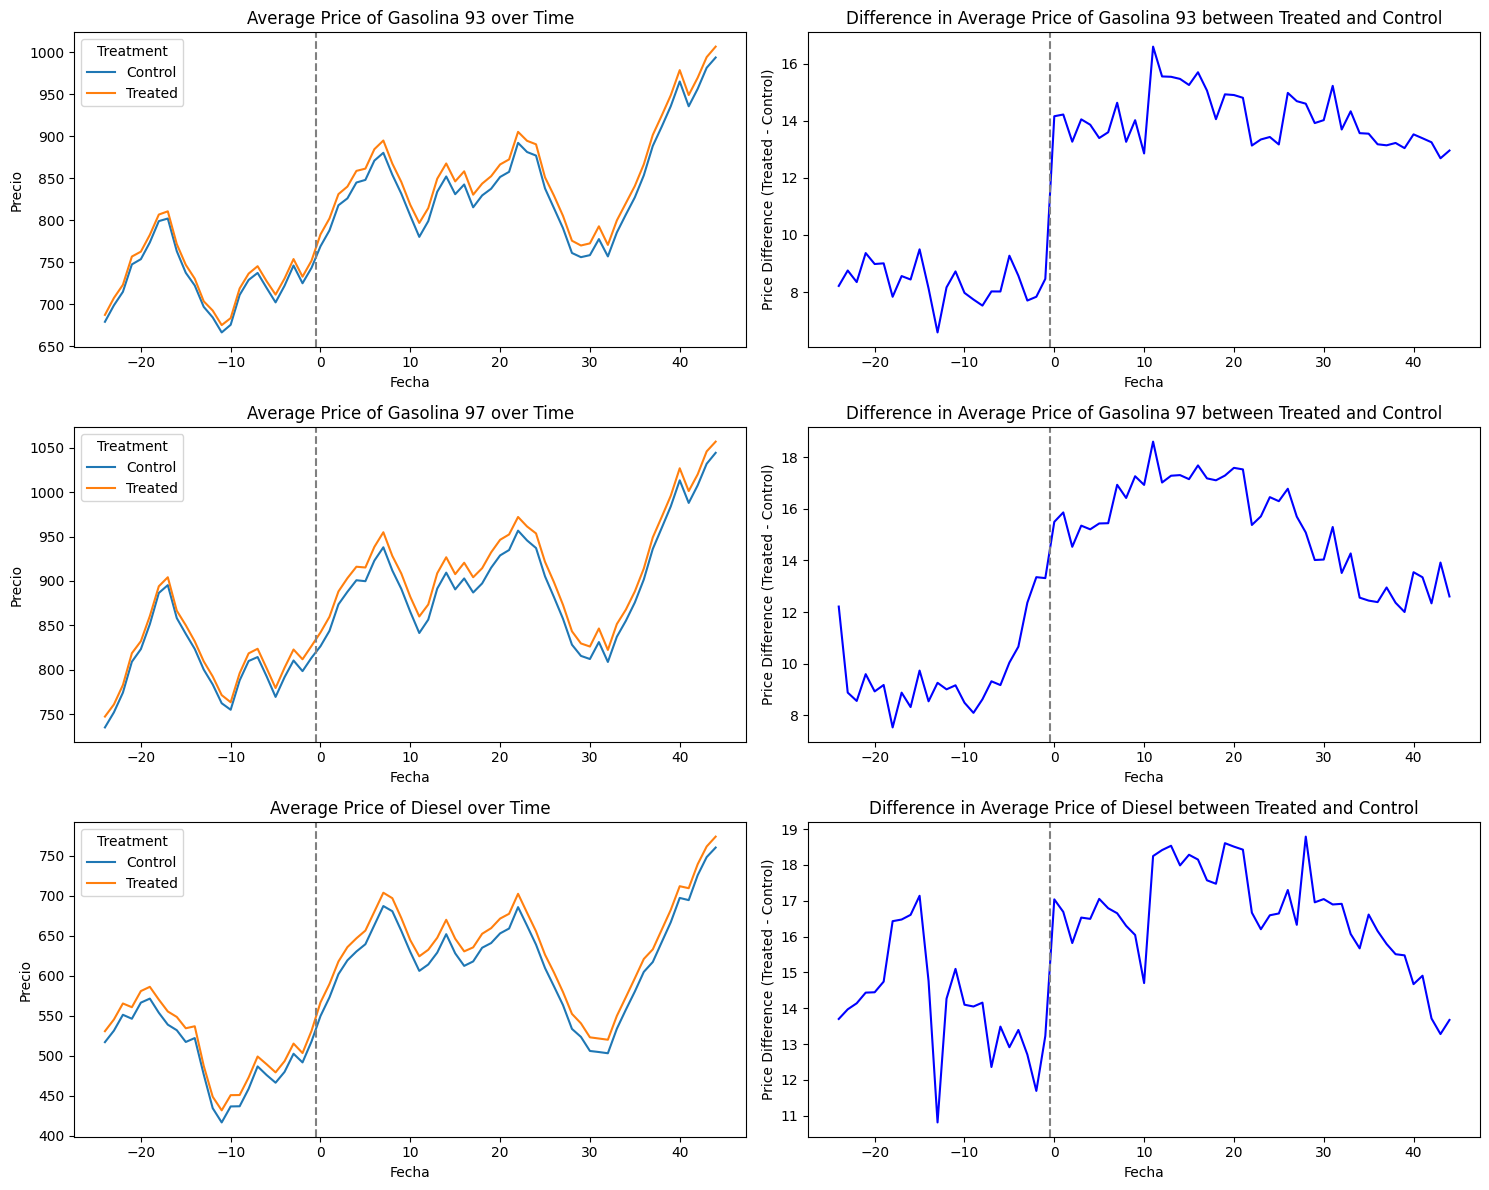

In [42]:
#| label: fig-price-treat
#| fig-cap: Price Evolution in Combustibles, by Treatment
#| code-fold: true
import pandas as pd
import matplotlib.pyplot as plt

# Plot the average price over time for each treatment group
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Filter DataFrame for Combustible=='Petroleo Diesel'
filtered_df = df[df['Combustible'] == 'Gasolina 93']

# Group by 'Treated' and 'date' and calculate the mean price
avg_price = filtered_df.groupby(['Treated', 'event_date'])['Precio'].mean().reset_index()

# First subplot
for Treated, data in avg_price.groupby('Treated'):
    axes[0,0].plot(data['event_date'], data['Precio'], label=Treated)

# Add vertical lines
axes[0,0].axvline(-0.5, linestyle='--', color='grey')

# Set labels and title
axes[0,0].set_xlabel('Fecha')
axes[0,0].set_ylabel('Precio')
axes[0,0].set_title('Average Price of Gasolina 93 over Time')
axes[0,0].legend(title='Treatment', loc='best')

# Second subplot
# Pivot the dataframe to have treated and control groups as columns
pivot_avg_price = avg_price.pivot(index='event_date', columns='Treated', values='Precio')

# Calculate the difference between treated and control
difference = pivot_avg_price['Treated'] - pivot_avg_price['Control']

# Plot the difference over time
axes[0,1].plot(difference.index, difference.values, color='blue')

# Add vertical lines
axes[0,1].axvline(-0.5, linestyle='--', color='grey')

# Set labels and title
axes[0,1].set_xlabel('Fecha')
axes[0,1].set_ylabel('Price Difference (Treated - Control)')
axes[0,1].set_title('Difference in Average Price of Gasolina 93 between Treated and Control')



# Filter DataFrame for Combustible=='Gasolina 97'
filtered_df = df[df['Combustible'] == 'Gasolina 97']

# Group by 'Treated' and 'date' and calculate the mean price
avg_price = filtered_df.groupby(['Treated', 'event_date'])['Precio'].mean().reset_index()

# First subplot
for Treated, data in avg_price.groupby('Treated'):
    axes[1,0].plot(data['event_date'], data['Precio'], label=Treated)

# Add vertical lines
axes[1,0].axvline(-0.5, linestyle='--', color='grey')

# Set labels and title
axes[1,0].set_xlabel('Fecha')
axes[1,0].set_ylabel('Precio')
axes[1,0].set_title('Average Price of Gasolina 97 over Time')
axes[1,0].legend(title='Treatment', loc='best')

# Second subplot
# Pivot the dataframe to have treated and control groups as columns
pivot_avg_price = avg_price.pivot(index='event_date', columns='Treated', values='Precio')

# Calculate the difference between treated and control
difference = pivot_avg_price['Treated'] - pivot_avg_price['Control']

# Plot the difference over time
axes[1,1].plot(difference.index, difference.values, color='blue')

# Add vertical lines
axes[1,1].axvline(-0.5, linestyle='--', color='grey')

# Set labels and title
axes[1,1].set_xlabel('Fecha')
axes[1,1].set_ylabel('Price Difference (Treated - Control)')
axes[1,1].set_title('Difference in Average Price of Gasolina 97 between Treated and Control')



# Filter DataFrame for Combustible=='Petroleo Diesel'
filtered_df = df[df['Combustible'] == 'Petroleo Diesel']

# Group by 'Treated' and 'date' and calculate the mean price
avg_price = filtered_df.groupby(['Treated', 'event_date'])['Precio'].mean().reset_index()

# First subplot
for Treated, data in avg_price.groupby('Treated'):
    axes[2,0].plot(data['event_date'], data['Precio'], label=Treated)

# Add vertical lines
axes[2,0].axvline(-0.5, linestyle='--', color='grey')

# Set labels and title
axes[2,0].set_xlabel('Fecha')
axes[2,0].set_ylabel('Precio')
axes[2,0].set_title('Average Price of Diesel over Time')
axes[2,0].legend(title='Treatment', loc='best')

# Second subplot
# Pivot the dataframe to have treated and control groups as columns
pivot_avg_price = avg_price.pivot(index='event_date', columns='Treated', values='Precio')

# Calculate the difference between treated and control
difference = pivot_avg_price['Treated'] - pivot_avg_price['Control']

# Plot the difference over time
axes[2,1].plot(difference.index, difference.values, color='blue')

# Add vertical lines
axes[2,1].axvline(-0.5, linestyle='--', color='grey')

# Set labels and title
axes[2,1].set_xlabel('Fecha')
axes[2,1].set_ylabel('Price Difference (Treated - Control)')
axes[2,1].set_title('Difference in Average Price of Diesel between Treated and Control')

plt.tight_layout()
plt.show()

Notably, the market's high price transparency is reflected in closely aligned pre-merger prices between treated and non-treated stations. However, this coherence is less pronounced in the case of Diesel, where price trends in time appear to diverge. 

Nevertheless, the graphical assessment suggests that the crucial assumption of the Difference-in-Differences (DiD) methodology —the parallel trend assumption— appears to be upheld within our sample, particularly evident for Gasoline 93 and 97. Our event-study framework aims to further elucidate and quantify these patterns.

## 4.3. Empirical Model

I examined the impact of the merger on retail gasoline prices within affected local markets using a difference-in-differences (DiD) framework that compares the price changes in a selection of stations that were located in overlap areas with the change in the same outcome variable in other stations from the non-overlap areas before and after the merger. My baseline specification takes the following form:

$$
P_{it} = \beta \times Treat_i\times \textbf{1}[t-t^*_0\geq0] + \gamma_t + \lambda_i + \varepsilon_{it}
$$

where the outcome variable, $P_{it}$, denotes the price of service station $i$ in year-month $t$. The treatment variable, $Treat_i$, takes the value of $1$ if station $i$ is located within the 5 kilometers of radius distance towards the target firm. The post-period indicator variable,  $\textbf{1}[t-t^*_0\geq0]$, equals 1 if period $t$ belongs to the post-merger period (i.e., after January 2018) whose starting period is $t^*_0 $ , and 0 otherwise. Year-month and unit fixed effects are captured by $\gamma_t$ and $\lambda_i$, respectively. The coefficient of interest is $\beta$, which measures the average treatment effect of the merger. It identifies the additional variation in prices experienced by the stations in overlap areas compared to the control stations after the merger took place. 

Under certain assumptions, parameter $\beta$ capture the causal effect of the treatment on the outcome. In our context, these effects are primarily identified by comparing units in the treated areas and units in no-treated areas, before and after the merger phase. The crucial identifying assumption is the so-called **parallel trends assumption** of a DiD model: that absent the merger, the treated service stations would have experienced the same outcome trend as the control stations.

In addition, I also report estimates from a more flexible specification that allows the coefficient to vary by the relative periods after the merger, by estimating the following equation:

$$
P_{it} = \sum_{h=T_1}^{T_0}(\beta_h \times Treat_i\times \textbf{1}[t-t^*_s\geq0]) + \gamma_t + \lambda_i + \varepsilon_{it}
$$

where $T_0$ and $T_1$ are the lowest and highest number of lags and leads, respectively, to consider surrounding the treatment period. Because I normalize the coefficient on the periods just prior to the merger announcement to zero (i.e., $\beta_{-1}=0$), each coefficient of $\beta_h$ can be interpreted as the price change in treated stations relative to no-treated stations after $h$ periods of the merger, with all of the $\beta_h$'s being estimated relative to the omitted year (i.e., $h=-1$). 

Using this flexible model has two advantages. First, I can visually test the key identifying assumption, which is the parallel-trends assumption: abstent the acquisition, the prices between overlap and non-overlap areas would have evolved in parallel. Although this assumption is fundamentally untestable, plotting the $\beta_h$'s of pre-periods (i.e., $\beta_{-8}$ to $\beta_{-2}$) can provide visual evidence. Second, this event-study allows the assessment of the time-evolving effects of the merger. This flexible specification enables me to capture such time-varying effects.

# 5. Main Results

## 5.1. Two-Way Fixed Effects Results

@tbl-twfe1, @tbl-twfe2 and @tbl-twfe3 report the baseline results from estimating the specification described in Equation 1 on **Gasoline 93, 97 and Diesel prices, respectively**:

In [7]:
#| label: tbl-twfe1
#| tbl-cap: TWFE Results (Gasoline 93)
#| code-fold: true
import pyfixest as pf

# Filter by Gasolina 93
df93 = df[(df['Combustible'] == 'Gasolina 93')]

# TWFE Estimation
feols1 = pf.feols("Precio ~ treat*Post | Id + date", data=df93, vcov={"CRV1": "Id"})
feols1.tidy().reset_index()

,Coefficient,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
0,treat:Post,5.747088,0.595788,9.646201,1.998401e-15,4.563085,6.931091


In [44]:
#| label: tbl-twfe2
#| tbl-cap: TWFE Results (Gasoline 97)
#| code-fold: true
import pyfixest as pf

# Filter by Gasolina 97
df97 = df[(df['Combustible'] == 'Gasolina 97')]

# TWFE Estimation
feols1 = pf.feols("Precio ~ treat*Post | Id + date", data=df97, vcov={"CRV1": "Id"})
feols1.tidy().reset_index()

,Coefficient,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
0,treat:Post,5.689687,0.62263,9.138146,2.131628e-14,4.45234,6.927033


In [45]:
#| label: tbl-twfe3
#| tbl-cap: TWFE Results (Diesel)
#| code-fold: true
import pyfixest as pf

# Filter by Diesel
dfdiesel = df[(df['Combustible'] == 'Petroleo Diesel')]

# TWFE Estimation
feols1 = pf.feols("Precio ~ treat*Post | Id + date", data=dfdiesel, vcov={"CRV1": "Id"})
feols1.tidy().reset_index()

,Coefficient,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
0,treat:Post,2.496932,0.971307,2.570692,0.01183,0.566663,4.427201


The estimated average effect on all these cases suggests that the merger caused a statistically significant average increase in price in overlap areas by around $5-6 Chilean pesos for the Gasoline 93 and 97 and around $2-3 for Diesel. These price effects are all below 1%.

## 5.2. Event-Study Results

I now estimate the event-study specification outlined in Equation 2 with the period before the merger as the reference period. @fig-eventstudy1, @fig-eventstudy2 and @fig-eventstudy3 shows the the estimated coefficients (and the corresponding 95% confidence intervals) after controlling for observed characteristics of the TWFE model.

In [99]:
#| echo: false
from lets_plot import *
LetsPlot.setup_html()

In [146]:
#| label: fig-eventstudy1
#| fig-cap: Event Study Results - Gasoline 93
#| code-fold: true


df93 = df[(df['Combustible'] == 'Gasolina 93')]

feols_event_study = pf.feols(
    "Precio ~ i(event_date, treat, ref=-1) | Id + event_date",
    data=df93,
    vcov={"CRV1": "Id"}
)


feols_event_study.iplot(
    coord_flip=False,
    #title="TWFE-Estimator",
    figsize=[900, 400],
    xintercept=22.5,
    yintercept=0
) + theme(legend_position='none') + scale_color_viridis(option="magma", end=0.5)

In [147]:
#| label: fig-eventstudy2
#| fig-cap: Event Study Results - Gasoline 97
#| code-fold: true

df97 = df[(df['Combustible'] == 'Gasolina 97')]

feols_event_study = pf.feols(
    "Precio ~ i(event_date, treat, ref=-1) | Id + event_date",
    data=df97,
    vcov={"CRV1": "Id"}
)

feols_event_study.iplot(
    coord_flip=False,
    title="TWFE-Estimator",
    figsize=[900, 400],
    xintercept=22.5,
    yintercept=0,
) + theme(legend_position='none') + scale_color_viridis(option="magma")

In [153]:
#| label: fig-eventstudy3
#| fig-cap: Event Study Results - Diesel
#| code-fold: true

dfdiesel = df[(df['Combustible'] == 'Petroleo Diesel')]

feols_event_study = pf.feols(
    "Precio ~ i(event_date, treat, ref=-1) | Id + event_date",
    data=dfdiesel,
    vcov={"CRV1": "Id"}
)

feols_event_study.iplot(
    coord_flip=False,
    #title="TWFE-Estimator",
    figsize=[900, 400],
    xintercept=22.5,
    yintercept=0,
) + theme(legend_position='none') + scale_color_viridis(option="magma", begin=0.7)

The visual evidence support that the parallel trend assumption holds, which is the main identifying assumption to interpret the effects as causal. In all models, the estimated coefficients for the pre-treatment period are close to zero and statistically insignificant. After the merger, I found that service station prices increased significantly, confirming my baseline regression results. 

It's worth noting that the results for Gasoline 93 are particularly clear in @fig-eventstudy1, with treatment effects exhibiting persistence or stability post-merger. Conversely, in the case of Gasoline 97, the treatment effects tend to diminish after approximately 20 months. Similar downward trends are observed for diesel prices.

# 6. Conclusions: Effect Sizes

Our empirical analysis shows an increase in gasoline prices after the acquisition of CGL. But, **how large are these effects?** Previous research in the Retail Gasoline market seems to indicate that these results are quite modest. In [Lagos (2018)](https://onlinelibrary.wiley.com/doi/abs/10.1111/joie.12188), for example, the author studied the merger between two large Chilean gasoline retailers, finding effects on _margins_ between 0.5% to 4% depending on the specification and the location of gas stations. This comparison suggests that the observed effects in our study may be comparatively negligible.

**How do these effects correlate with antitrust enforcement?** Does these results justify FNE's merger decision to approve it? The US Horizontal Merger Guidelines (2010) indicates that a merger is unlikely to raise significant unilateral effects concerns if the [_Gross Upward Pricing Pressure Index_](https://media.crai.com/wp-content/uploads/2020/09/16163618/the-use-of-UPPIs-in-merger-analysis-Moresi-Feb-2010.pdf) (GUPPI) is proportionately small. In practice, that amount is often considered to be less than 5%. [Bhattacharya, Illanes and Stillerman (2023)](https://www.stern.nyu.edu/sites/default/files/2023-05/Mergers.pdf) found that competition agencies challenge mergers they expect would increase average prices more than 8–9% . Even though moving to a 5% threshold would reduce aggregate price increases by about 1 percentage point, this threshold would lead to significantly higher administrative burden, nearly tripling the number of mergers the agencies must challenge.

In either case, the findings from my study suggest that the observed effects are too low to raise competitive concerns. Furthermore, these results do not account for potential pro-competitive effects, such as efficiency gains, which could offset any negative impacts.